# Tecnologias e Aplicações - Computação Gráfica


Grupo:

* A82202 - Joel Gama 
* A82491 - Tiago Pinheiro
* A75362 - Vitor Gomes

Dataset utilizado: []()

### References

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.youtube.com/watch?v=yH1cF7GnoIo    

https://www.datacamp.com/community/tutorials/tensorflow-tutorial    



In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np

import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

### Batch size

Batch size is an important parameter when training a network. It can influence speed and generalization, not necessarily in the same direction. There is no golden rule for the batch size but 32 is a commom number to start with.

See: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

Try with different batch sizes.

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 32

### Preparação para o carregamento de imagens

Definição da pasta onde se encontram as imagens de treino

In [3]:
data_dir = pathlib.Path('gtsrb/train_images/')
signs = list(data_dir.glob('00001/*'))
  
classNames = np.array(os.listdir(data_dir))
classNames


array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007', '00008', '00009', '00010', '00011', '00012', '00013',
       '00014', '00015', '00016', '00017', '00018', '00019', '00020',
       '00021', '00022', '00023', '00024', '00025', '00026', '00027',
       '00028', '00029', '00030', '00031', '00032', '00033', '00034',
       '00035', '00036', '00037', '00038', '00039', '00040', '00041',
       '00042'], dtype='<U5')

### Funções auxiliares

Definição de funções auxiliares para o carregamento de imagens para um dataset

* get_bytes_and_label(file_path):

    * Recebe um tensor object com um caminho para uma imagem.
    * Devolve um tensor com a imagem e a sua categoria.

* validacao(file_path,valsplit):
    * Recebe um tensor com a localização de uma imagem e a fração do dataset de validação.
    * Devolve um booleano indicando se a imagem deve pertencer ou não ao dataset de validação.

In [4]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def validacao(file_path,valsplit):
    
    parts = tf.strings.split(file_path, os.path.sep)
    seq_num = tf.strings.to_number(tf.strings.split(parts[-1], '_')[0])
    
    return (int(seq_num)%round(1/valsplit)) == 0

### Carregamento de imagens

Nesta secção é realizado o carregamento das imagens para os datasets de treino e de validação.
Visto que o dataset utilizado é constituído por imagens de sequências de vídeo, o carregamento destas para a criação dos datasets de treino e de validação é feito de forma a que imagens pertencentes à mesma sequência de vídeo fiquem no mesmo dataset e assim as redes neuronais não sejam validadas com um dataset parecido com o que treinaram.

A varíavel valsplit define a porção de imagens do dataset a carregar que irá pertencer ao dataset para validação. Pela forma que está implementada a definição destes datasets, o split real será um pouco maior que o definido. Escolheu-se um split para o dataset de validação que foi com o qual se obteve resultados melhores e mais consistentes. 

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files("gtsrb/train_images/*/*.png")

valsplit = 0.2

valset = listset.filter(lambda f: validacao(f,valsplit))
valset = valset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

trainset = listset.filter(lambda f: not(validacao(f,valsplit)))
trainset = trainset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)


### Informação acerca dos datasets criados

Impressão de informação sobre os datasets criados. Isto é, a largura, altura e nº de canais que as suas imagens possuem, assim como o número total de imagens presentes nos datasets.

In [6]:

for image, label in valset.take(1):
  print("Image shape: ", image.numpy().shape)
  
valset_length = [i for i,_ in enumerate(valset)][-1] + 1
print("Total images in dataset: ",valset_length)

for image, label in trainset.take(1):
  print("Image shape: ", image.numpy().shape)
  
trainset_length = [i for i,_ in enumerate(trainset)][-1] + 1
print("Total images in dataset: ",trainset_length)


Image shape:  (32, 32, 3)
Total images in dataset:  8340
Image shape:  (32, 32, 3)
Total images in dataset:  30869


### Preparação dos datasets

Shuffle dos datasets para tornar a sua ordem aleatória

In [7]:
    '''
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size = dataset_length)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.repeat()
    '''
    valset = valset.cache()
    valset = valset.shuffle(buffer_size = valset_length)
    valset = valset.batch(batch_size=BATCH_SIZE)
    valset = valset.prefetch(buffer_size=AUTOTUNE)
    valset = valset.repeat()

    trainset = trainset.cache()
    trainset = trainset.shuffle(buffer_size = trainset_length)
    trainset = trainset.batch(batch_size=BATCH_SIZE)
    trainset = trainset.prefetch(buffer_size=AUTOTUNE)
    trainset = trainset.repeat()



### Carregamento e preparação do dataset de teste

In [8]:
testSplit = 0.8

testset = tf.data.Dataset.list_files("gtsrb/test_images/*/*.png")
print(testset)
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size=BATCH_SIZE)


<ShuffleDataset shapes: (), types: tf.string>


### Visualização de um batch de imagens de treino

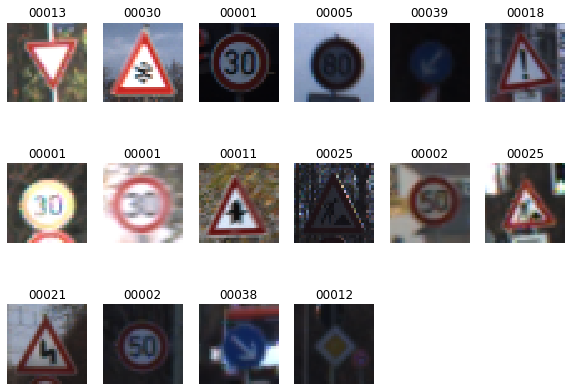

In [9]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(trainset))        
show_batch(image_batch, label_batch.numpy())

### Build a simple network


Optou-se por usar uma rede neuronal convolucional por serem as mais aconselhadas para reconhecimento e classificação de imagens. Estas costumam começar com um número reduzido de filtros a aplicar que vai aumentando, razão pela qual se optou por aplicar 2 convoluções com 32 filtros seguidas de 2 convoluções com 128 filtros.
O algoritmo Adam foi utilizado como otimizador com uma taxa de aprendizagem de 0.001 que foi com o qual se obteve resultados melhores e uma convergência mais rápida.
O Max-Pooling aplicado ajuda a generalizar características encontradas nas imagens combatendo o over-fitting. A aplicação desta camada reduz também o número de parâmetros e o consequente tempo de computação.
No final desta rede neuronal existem 2 camadas fully connected. A primeira envolve 256 nodos e a segunda 43 nodos que representam o total de classificações possíveis 

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam, Adadelta

def cnn55D3L2FC(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(imgSize, imgSize, channels),
                     activation='relu'))                     
    model.add(Conv2D(32, (3, 3), activation='relu') ) 
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu') )   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu') )   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.3))
 
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    #model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.4))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.4))

    #model.add(GlobalAveragePoolingD())
    
    model.add(Dense(classCount, activation='softmax'))

 
    
    opt = Adam(lr=0.001)
    #opt = Adadelta(lr=1)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
    return model

models = []

models.append(cnn55D3L2FC(43, IMAGE_SIZE, 3))
models.append(cnn55D3L2FC(43, IMAGE_SIZE, 3))
models.append(cnn55D3L2FC(43, IMAGE_SIZE, 3))
models.append(cnn55D3L2FC(43, IMAGE_SIZE, 3))
models.append(cnn55D3L2FC(43, IMAGE_SIZE, 3))




### Draw a diagram of the network

This requires installing some packages, namely graphviz

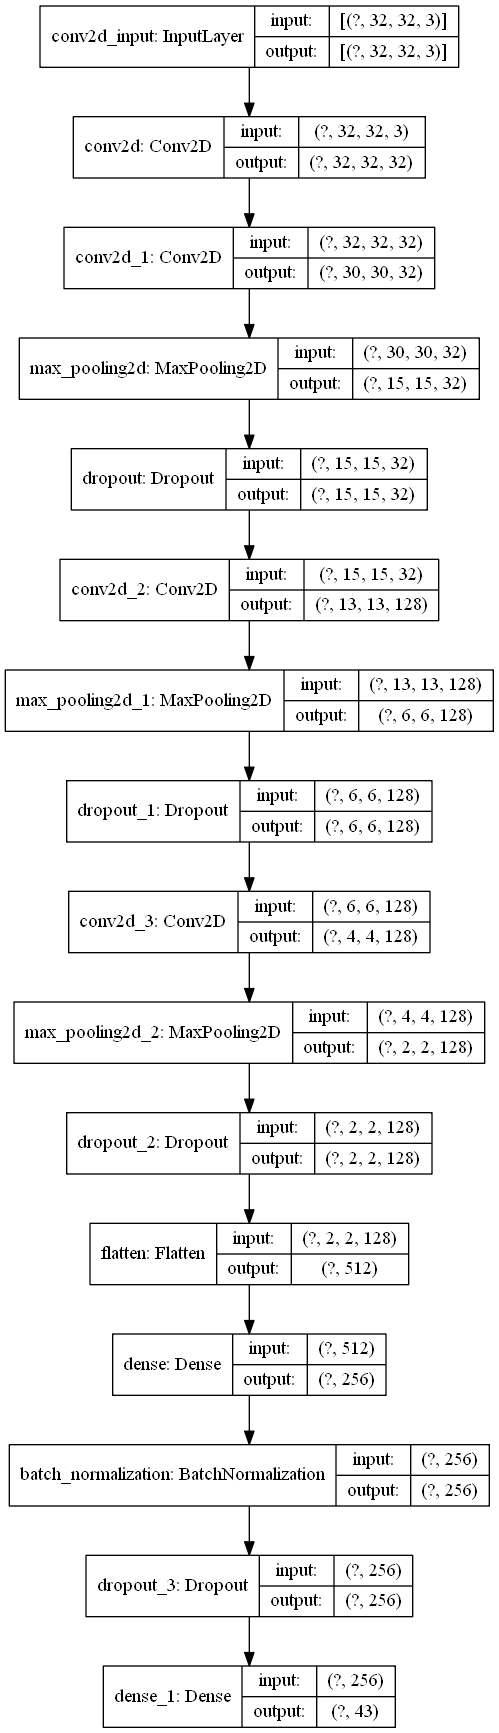

In [11]:
tf.keras.utils.plot_model(models[0], 'multi_input_and_output_model.png', show_shapes=True)

### Display a table with model information

When building a model kee an eye on the number of trainable parameters. Try to keep it below 10 million

In [12]:
print(models[0].summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0

### Treino da rede neuronal

Nesta secção é efetuado o treino da rede neuronal. 

Nesta secção foram feitos testes com alterações dos seguintes parâmetros:

* `epocas` - Número de épocas a treinar
* `save` - Define se os resultados das diferentes épocas devem ser guardados
* `saveBestOnly` - Define se deve ser guardado apenas o resultado da melhor época

O melhor desempenho das redes neuronais treinadas foram obtidos com a gravação de apenas os melhores resultados.
O nº de épocas foi definido para 20, que é o número de épocas a partir da qual se deixaram de ver melhorias significativas nos resultados dos testes das redes neuronais. A evolucão da accuracy e da loss da rede treinada para 200 iterações pode ser observada nas seguintes imagens.

![Accuracy](img/200-accu.png)
![Loss](img/200-loss.png)

Destas imagens podemos inferir que não haverá grandes vantagens em treinar esta rede por mais de 20 épocas.

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint


epocas = 20
save = True

if save:

    if not os.path.exists("checkpoints"):
        os.mkdir("checkpoints")
    
    saveBestOnly=True
    
    checkpointers = []

    checkpointers.append(ModelCheckpoint(filepath="checkpoints/best_weights0-{epoch:03d}.hdf5", 
                                   monitor = 'val_categorical_accuracy',
                                   verbose=1, 
                                   save_best_only=saveBestOnly))

    checkpointers.append(ModelCheckpoint(filepath="checkpoints/best_weights1-{epoch:03d}.hdf5", 
                                   monitor = 'val_categorical_accuracy',
                                   verbose=1, 
                                   save_best_only=saveBestOnly))

    checkpointers.append(ModelCheckpoint(filepath="checkpoints/best_weights2-{epoch:03d}.hdf5", 
                                   monitor = 'val_categorical_accuracy',
                                   verbose=1, 
                                   save_best_only=saveBestOnly))

    checkpointers.append(ModelCheckpoint(filepath="checkpoints/best_weights3-{epoch:03d}.hdf5", 
                                   monitor = 'val_categorical_accuracy',
                                   verbose=1, 
                                   save_best_only=saveBestOnly))

    checkpointers.append(ModelCheckpoint(filepath="checkpoints/best_weights4-{epoch:03d}.hdf5", 
                                   monitor = 'val_categorical_accuracy',
                                   verbose=1, 
                                   save_best_only=saveBestOnly))


    history=[]

    history.append(models[0].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,
              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE, callbacks=[checkpointers[0]]))

    print(models[0].evaluate(testset))


    history.append(models[1].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,
              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE, callbacks=[checkpointers[1]]))
    print(models[1].evaluate(testset))


    history.append(models[2].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,
              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE, callbacks=[checkpointers[2]]))
    print(models[2].evaluate(testset))


    history.append(models[3].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,
              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE, callbacks=[checkpointers[3]]))
    print(models[3].evaluate(testset))

    history.append(models[4].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,
              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE, callbacks=[checkpointers[4]]))
    print(models[4].evaluate(testset))
else:
    
    history=[]

    history.append(models[0].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,
              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE))

    print(models[0].evaluate(testset))


    history.append(models[1].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,
              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE))
    print(models[1].evaluate(testset))


    history.append(models[2].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,
              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE))
    print(models[2].evaluate(testset))


    history.append(models[3].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,
              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE))
    print(models[3].evaluate(testset))

    history.append(models[4].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,
              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE))
    print(models[4].evaluate(testset))
    


Train for 1929.3125 steps, validate for 521.25 steps
Epoch 1/200
1930/1929 [==============================] - 19s 10ms/step - loss: 1.4664 - categorical_accuracy: 0.5783 - val_loss: 0.2890 - val_categorical_accuracy: 0.9242
Epoch 2/200
1930/1929 [==============================] - 11s 6ms/step - loss: 0.2929 - categorical_accuracy: 0.9094 - val_loss: 0.1638 - val_categorical_accuracy: 0.9524
Epoch 3/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.1969 - categorical_accuracy: 0.9393 - val_loss: 0.1459 - val_categorical_accuracy: 0.9590
Epoch 4/200
1930/1929 [==============================] - 11s 6ms/step - loss: 0.1606 - categorical_accuracy: 0.9498 - val_loss: 0.1289 - val_categorical_accuracy: 0.9664
Epoch 5/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.1256 - categorical_accuracy: 0.9615 - val_loss: 0.1350 - val_categorical_accuracy: 0.9627
Epoch 6/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.1168 - categoric

Epoch 96/200
1930/1929 [==============================] - 11s 6ms/step - loss: 0.0118 - categorical_accuracy: 0.9968 - val_loss: 0.0532 - val_categorical_accuracy: 0.9873
Epoch 97/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.0104 - categorical_accuracy: 0.9967 - val_loss: 0.0478 - val_categorical_accuracy: 0.9886
Epoch 98/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.0105 - categorical_accuracy: 0.9967 - val_loss: 0.0499 - val_categorical_accuracy: 0.9890
Epoch 99/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.0123 - categorical_accuracy: 0.9966 - val_loss: 0.0742 - val_categorical_accuracy: 0.9849
Epoch 100/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.0091 - categorical_accuracy: 0.9975 - val_loss: 0.0579 - val_categorical_accuracy: 0.9876
Epoch 101/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.0101 - categorical_accuracy: 0.9970 - val_loss: 0.0564 - val_c

Epoch 191/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.0060 - categorical_accuracy: 0.9983 - val_loss: 0.0453 - val_categorical_accuracy: 0.9892
Epoch 192/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.0052 - categorical_accuracy: 0.9983 - val_loss: 0.0538 - val_categorical_accuracy: 0.9892
Epoch 193/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.0060 - categorical_accuracy: 0.9984 - val_loss: 0.0434 - val_categorical_accuracy: 0.9898
Epoch 194/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.0083 - categorical_accuracy: 0.9977 - val_loss: 0.0578 - val_categorical_accuracy: 0.9863
Epoch 195/200
1930/1929 [==============================] - 11s 6ms/step - loss: 0.0050 - categorical_accuracy: 0.9983 - val_loss: 0.0641 - val_categorical_accuracy: 0.9855
Epoch 196/200
1930/1929 [==============================] - 11s 5ms/step - loss: 0.0067 - categorical_accuracy: 0.9980 - val_loss: 0.0571 - v

'\n    history.append(models[1].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,\n              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE))\n    print(models[1].evaluate(testset))\n\n\n    history.append(models[2].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,\n              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE))\n    print(models[2].evaluate(testset))\n\n\n    history.append(models[3].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,\n              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE))\n    print(models[3].evaluate(testset))\n\n    history.append(models[4].fit(trainset, steps_per_epoch = trainset_length/BATCH_SIZE,\n              epochs=epocas, validation_data = valset, validation_steps= valset_length/BATCH_SIZE))\n    print(models[4].evaluate(testset))\n    \n'

In [14]:
media = (models[0].evaluate(testset)[1]\
 + models[1].evaluate(testset)[1]\
 + models[2].evaluate(testset)[1]\
 + models[3].evaluate(testset)[1]\
 + models[4].evaluate(testset)[1])/5
        
print(media)

790/790 [==============================] - 4s 5ms/step - loss: 3.7622 - categorical_accuracy: 0.0116
0.214410138130188


In [15]:
'''
models[0].load_weights('best_weights0-017.hdf5')

models[0].evaluate(testset)

'''

"\nmodels[0].load_weights('best_weights0-017.hdf5')\n\nmodels[0].evaluate(testset)\n\n"

### Plot the training history

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


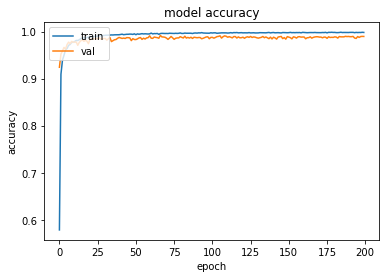

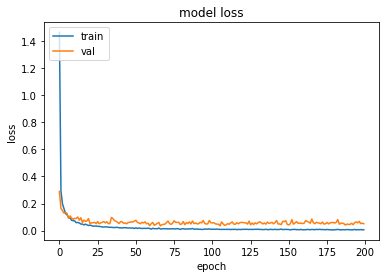

In [16]:

print(history[0].history.keys())

# summarize history for accuracy
plt.plot(history[0].history['categorical_accuracy'])
plt.plot(history[0].history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history[0].history['loss'])
plt.plot(history[0].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


### Evaluate the model on the test set

This is the accuracy number that really matters

In [17]:
models[0].evaluate(testset)
models[1].evaluate(testset)
models[2].evaluate(testset)
models[3].evaluate(testset)
models[4].evaluate(testset)


790/790 [==============================] - 4s 5ms/step - loss: 3.7622 - categorical_accuracy: 0.0116


[3.7622242333013802, 0.011638955]

# Secção para exibir a categorização de 30 imagens pelo modelo 0

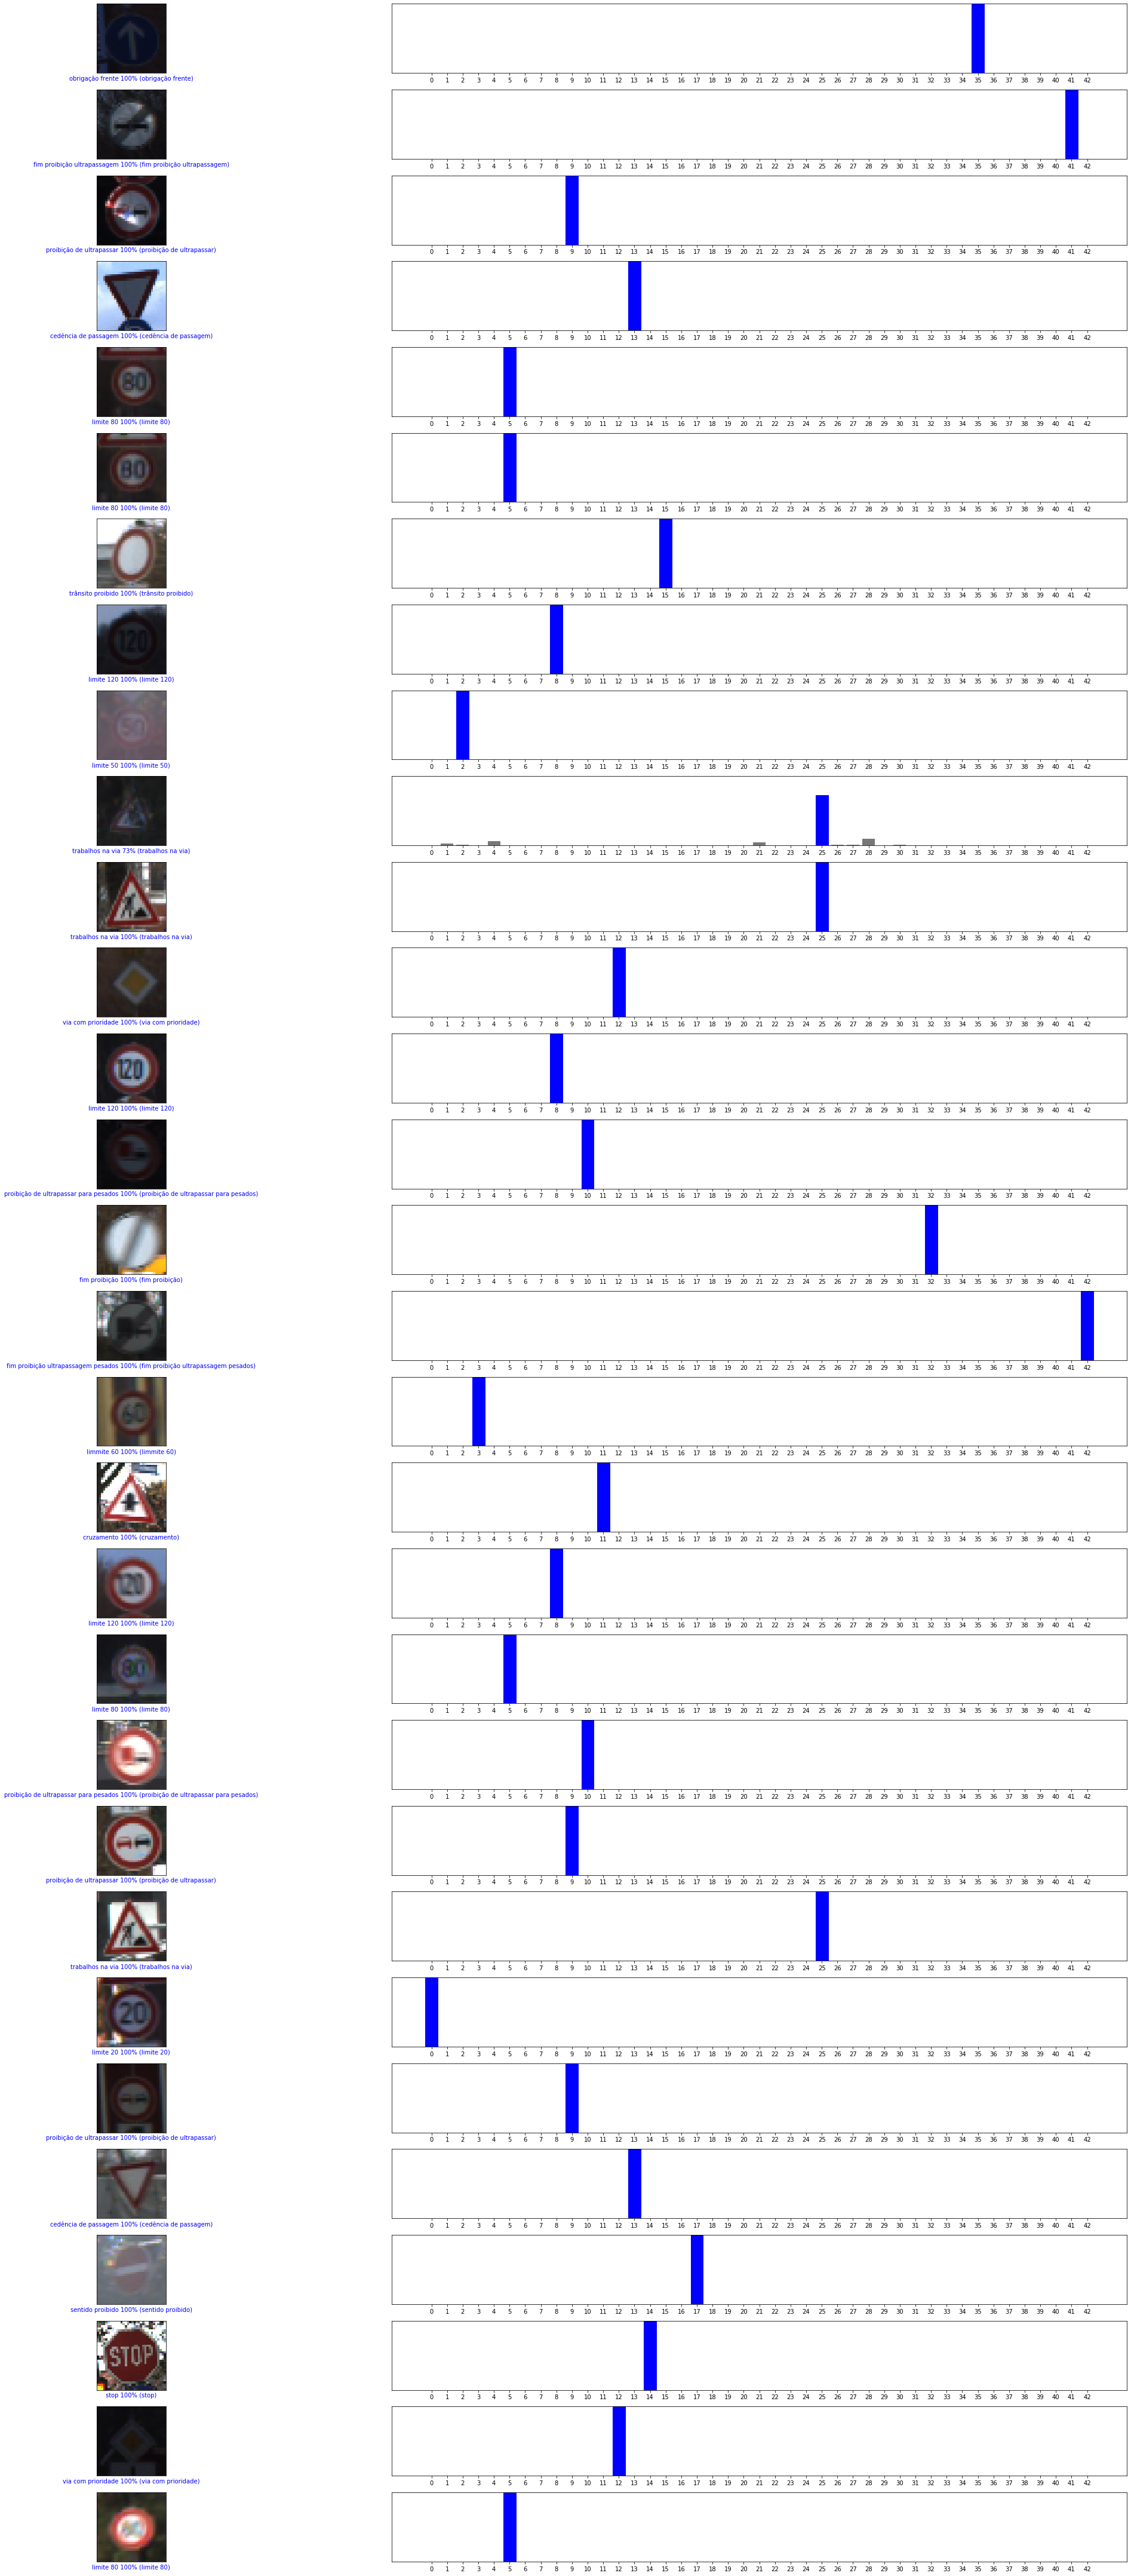

In [18]:

class_names = np.array(['limite 20','limite 30', 'limite 50', 'limmite 60', 'limite 70', 'limite 80', 'fim limite 80', 'limite 100', 'limite 120', 'proibição de ultrapassar', 'proibição de ultrapassar para pesados', 'cruzamento', 'via com prioridade', 'cedência de passagem', 'stop', 'trânsito proibido', 'trânsito proibido mercadorias', 'sentido proibido', 'perigo qualquer', 'curva esquerda', 'curva direita', 'curva esquerda e contracurva', 'lomba ou depressão', 'pavimento escorregadio', 'passagem estreita', 'trabalhos na via', 'sinalização luminosa', 'travessia de peões', 'crianças', 'ciclistas', 'neve', 'animais', 'fim proibição', 'obrigação direita', 'obrigação esquerda', 'obrigação frente', 'obrigação direita ou frente', 'obrigação frente ou esquerda', 'contornar pela direita', 'contornar pela esquerda', 'obrigação rotunda', 'fim proibição ultrapassagem', 'fim proibição ultrapassagem pesados'])

def plot_image(predictions_array, true_label, img):
  #predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  plt.imshow(img, cmap=plt.cm.binary)
  
    
  predicted_label = np.argmax(predictions_array)
  true_label = np.argmax(true_label)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(predictions_array, true_label):
  #predictions_array, true_label = predictions_array, true_label[i]
  true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks(range(43))
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 30
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(8*2*2*num_cols, 2*num_rows))

selected=0
for i in testset.take(-1):
  a = models[0].predict(i)
  image,label = i
  for j in range(BATCH_SIZE):
    plt.subplot(num_rows, 2*num_cols, 2*selected+1)
    plot_image(a[j], label.numpy()[j], image.numpy()[j])
    plt.subplot(num_rows, 2*num_cols, 2*selected+2)
    plot_value_array(a[j], label.numpy()[j])
    selected = selected + 1
    if selected >= num_images:
        break
  if selected >= num_images:
    break
        
  
plt.tight_layout()
plt.show()

# Secção para exibir até 30 imagens categorizadas incorretamento pelo modelo 0

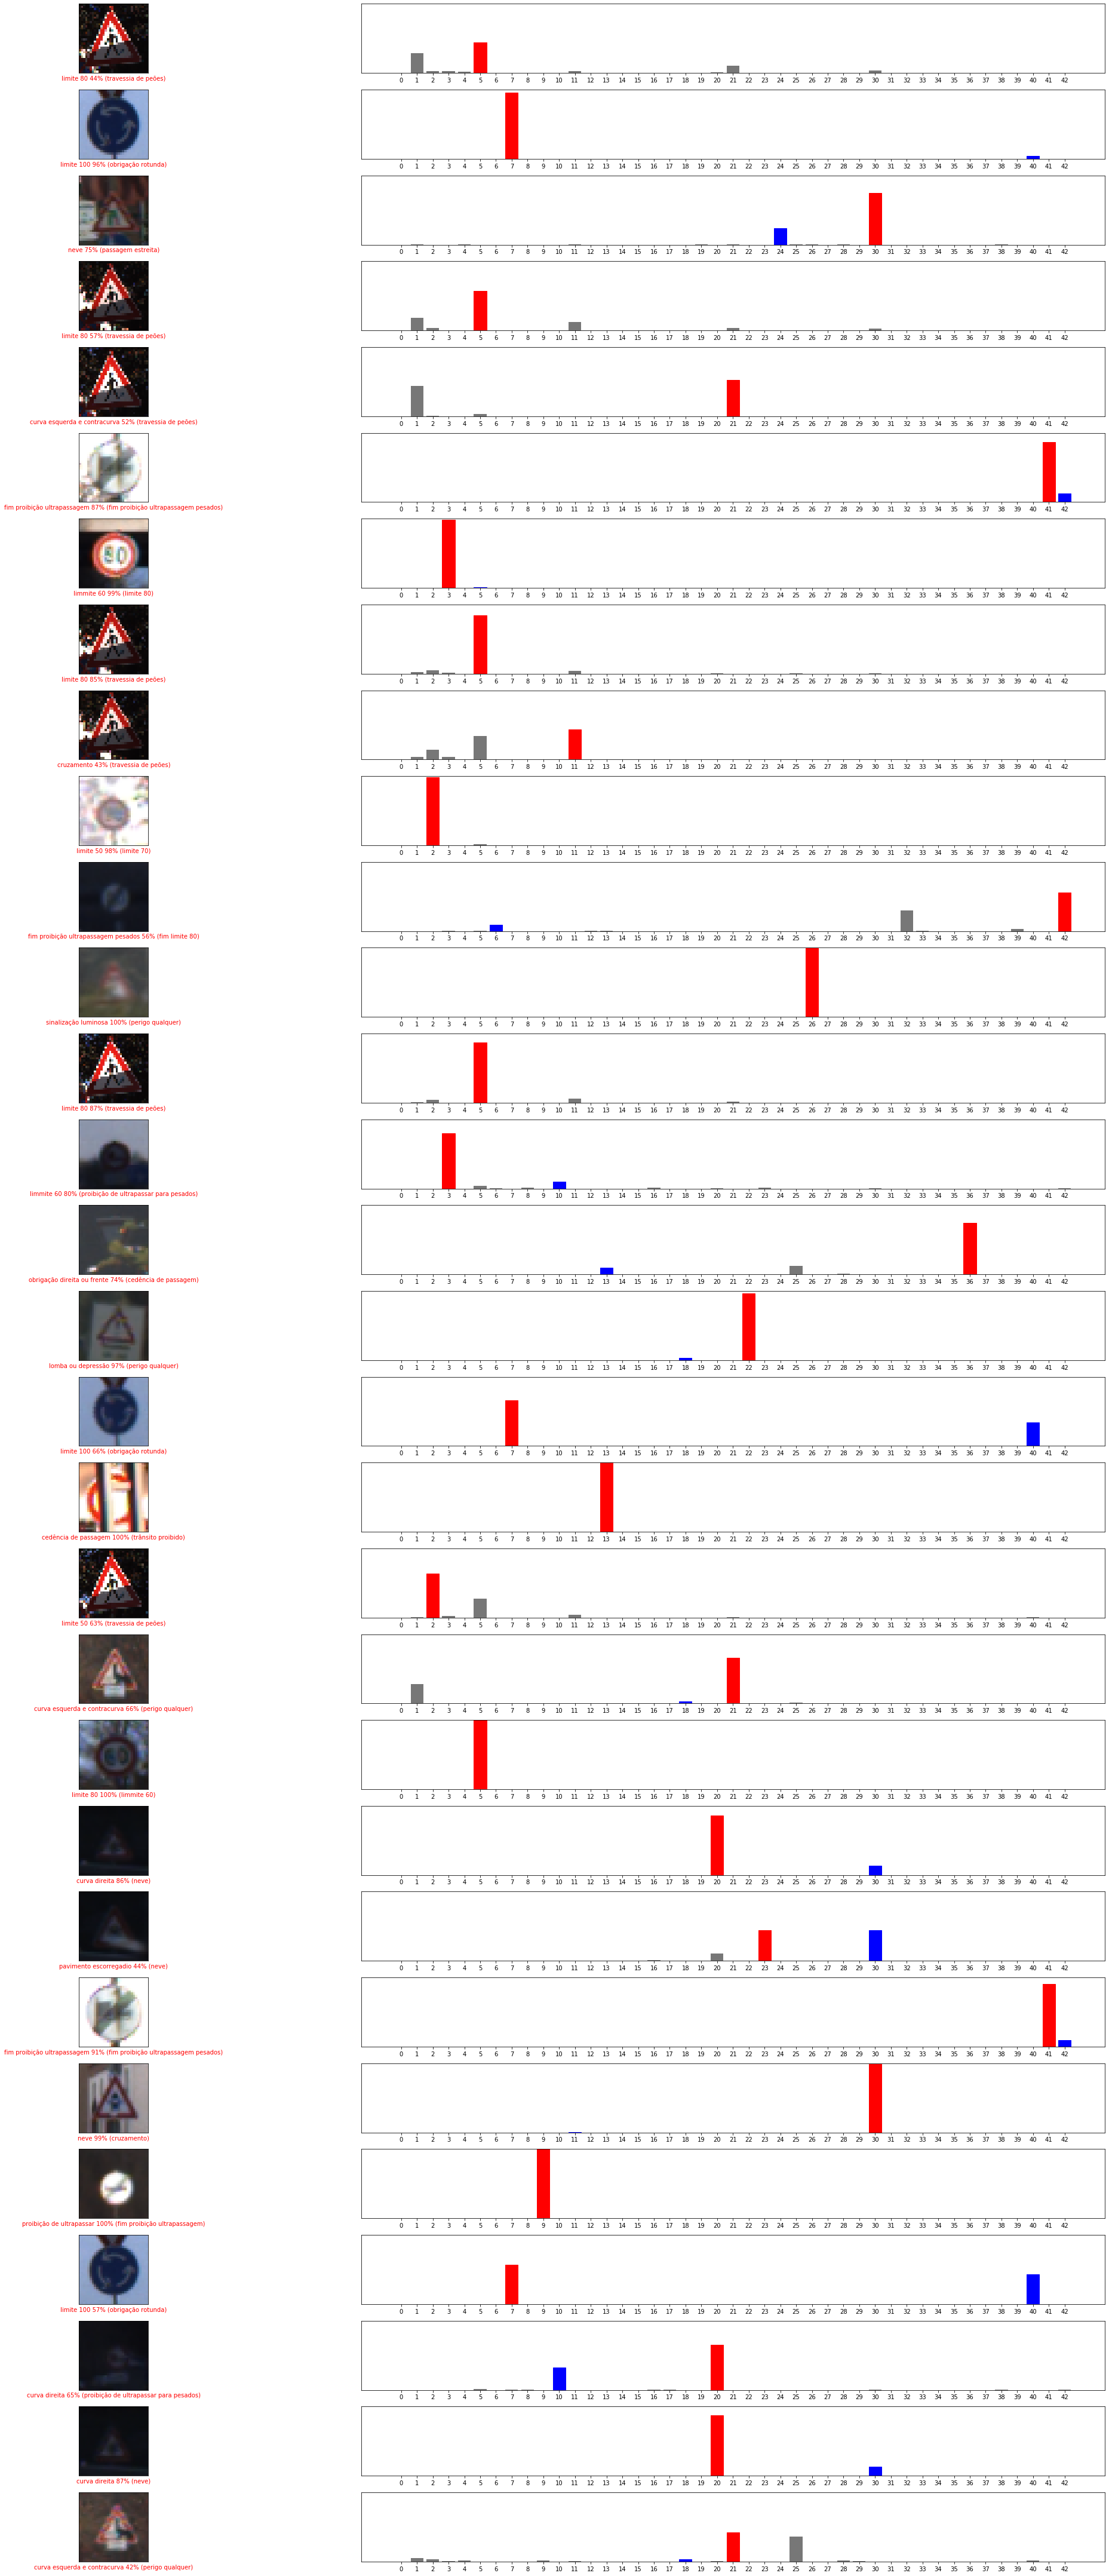

In [19]:

class_names = np.array(['limite 20','limite 30', 'limite 50', 'limmite 60', 'limite 70', 'limite 80', 'fim limite 80', 'limite 100', 'limite 120', 'proibição de ultrapassar', 'proibição de ultrapassar para pesados', 'cruzamento', 'via com prioridade', 'cedência de passagem', 'stop', 'trânsito proibido', 'trânsito proibido mercadorias', 'sentido proibido', 'perigo qualquer', 'curva esquerda', 'curva direita', 'curva esquerda e contracurva', 'lomba ou depressão', 'pavimento escorregadio', 'passagem estreita', 'trabalhos na via', 'sinalização luminosa', 'travessia de peões', 'crianças', 'ciclistas', 'neve', 'animais', 'fim proibição', 'obrigação direita', 'obrigação esquerda', 'obrigação frente', 'obrigação direita ou frente', 'obrigação frente ou esquerda', 'contornar pela direita', 'contornar pela esquerda', 'obrigação rotunda', 'fim proibição ultrapassagem', 'fim proibição ultrapassagem pesados'])

def plot_image(predictions_array, true_label, img):
  #predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  plt.imshow(img, cmap=plt.cm.binary)
  
    
  predicted_label = np.argmax(predictions_array)
  true_label = np.argmax(true_label)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


def plot_value_array(predictions_array, true_label):
  #predictions_array, true_label = predictions_array, true_label[i]
  true_label = np.argmax(true_label)
  plt.grid(False)
  plt.xticks(range(43))
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 30
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(8*2*2*num_cols, 2*num_rows))
errados=0
for i in testset.take(-1):
  a = models[0].predict(i)
  image,label = i
  for j in range(BATCH_SIZE):
    if np.argmax(a[j]) != np.argmax(label.numpy()[j]):
      plt.subplot(num_rows, 2*num_cols, 2*errados+1)
      plot_image(a[j], label.numpy()[j], image.numpy()[j])
      plt.subplot(num_rows, 2*num_cols, 2*errados+2)
      plot_value_array(a[j], label.numpy()[j])
      errados = errados + 1
    if errados >= num_images:
        break
  if errados >= num_images:
    break
  
plt.tight_layout()
plt.show()